# The Brachistochrone

The Brachistochrone is a physics problem posed by Johann Bernoulli in 1696.

What path gives us the shortest distance between two points? As most people know, in flat space the answer is a line. 

What path gives us the shortest time between two points? Assuming we are in a uniform gravitation field, the Brachistochrone curve is the path that minimizes the amount of time it takes to get between point A and B. What does that curve look like?

To set up the problem, we assume that point $a$ is located at $(0,0)$, and that point $b$ is at point $(x,y)$ where $y < 0$. Starting with a particle at rest at point $a$, and using conservation of energy $E = T + U$, we know that at point A the total energy is 0, and at point $b$, it is $\frac{1}{2}mv^2 - mgy$.  We set them equal to each other to get

$$ v = \sqrt{2 g y}$$

$s$ is the path the particle takes, so we know $\frac{ds}{dt} = v$. We can then rearrange the equation to get $\frac{ds}{v} = dt$ and integrate to get

$$ \Delta t = \int_a^b \frac{ds}{\sqrt{2 g y}}$$

We can express our goal as trying to find the path $s$ such that $\Delta t$ is minimum. Rearranging the variables we have

$$ \Delta t = \int_a^b \frac{\sqrt{dx^2 + dy^2}}{\sqrt{2 g y}} = \int_0^x \sqrt{\frac{1+ y'(x)}{2 g y}} dx = \int_0^x f\{y,y';x\} dx $$

So $\Delta t$ is a functional (its arguments are a function). We need to find the function $y$ that will minimize its value. Classicaly, this is a problem in the Calculus of Variations. Solving it requires plugging $f$ into the Euler-Lagrange equation and solving the resulting differential equation will find the minimal $y$.

$$ \frac{df}{dy} - \frac{d}{dx}\frac{df}{dy'} = 0 \qquad \text{Euler-Lagrange} $$

Plugging in $f$ into the above equation eventually leads to the differential equation of a cycloid.

$$ \left(\frac{dy}{dx}\right)^2 = \frac{2k-y}{y} $$

So in other words, the shape of the Brachistochrone curve is a cycloid. Cycloids cannot be expressed in closed form, but can be expressed in parametric form. 

$$ x = k(\theta-\sin\theta) $$
$$ y = k(1-\cos\theta) $$

k is the radius of the circle the cycloid is being drawn by. It is found by using the condition that the cycloid must pass through the point $(x,y)$. 

## Approximating the cycloid numerically

We can expand the cycloid function in a fourier series to get an approximation of the function and its derivative:

$$ y(x) \approx a_0 + \sum_{i=1}^n a_n \cos{\frac{xn}{2k}} + b_n \sin{\frac{xn}{2k}}$$
$$ y'(x) \approx \sum_{i=1}^n \frac{n b_n}{2k} \cos{\frac{xn}{2k}} -\frac{n a_n}{2k} \sin{\frac{xn}{2k}} $$

And we can get the fourier coeffcients with the following equation:

$$ a_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} y(x) \cos(\frac{nx}{2 k}) dx $$
$$ b_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} y(x) \sin(\frac{nx}{2 k}) dx $$

Since we can only express the cycloid parameterically, we change all the variables to $\theta$:

$$ a_n = \frac{k}{2\pi} \int_{-2\pi}^{2\pi}(1-\cos{\theta})^2 \cos(\frac{n}{2} (\theta-\sin{\theta})) d\theta $$
$$ b_n = \frac{k}{2\pi} \int_{-2\pi}^{2\pi}(1-\cos{\theta})^2 \sin(\frac{n}{2} (\theta-\sin{\theta})) d\theta = 0 $$ 

All the $b_n$ will be zero because the cycloid is an even function. We can then plug in this $y(x)$ and $y'(x)$ in our $\Delta t$ equation to actually see what the minimal time is. Of course, to get a good approximation of the cycloid, we will need quite a few terms in the fourier expansion (at least 100).

In [1]:
import numpy as np
import scipy
import sys, math
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import cma
from es import SimpleGA, CMAES, PEPG, OpenES

In [2]:
#constants
XFINAL = 10.0
YFINAL = -5.
FOURIER_TERMS = 10
g = -9.8 #m/s^2
K = 2.585999608432 #radius of the cycloid of the optimal brachistochrone. Gotten numerically from Mathematica
TFINAL = 3.50837   #final angle of the cycloid of the optimal brachistochrone. Gotten numerically from Mathematica
#FindRoot[Evaluate[{a*(t - Sin[t]) == XFINAL, a*(1 - Cos[t]) == YFINAL}], {a, 5}, {t, 3.2}, MaxIterations -> 1000]


In [3]:
def cycloid_coefficients(n):
    # n is number of sine coefficients and n+1 the number of cosine coeffcieints. 
    # change of variables to theta is necessary since cannot write in terms of y(x).
    # sine terms are all 0. cosine terms are non-zero.
    coefs = [0]*(2*n+1)
    def cos_coef(c,theta):
        return ((1-np.cos(theta))**2)*(np.cos((c/2.)*(theta-np.sin(theta))))
    def sin_coef(c,theta):
        return ((1-np.cos(theta))**2)*(np.sin((c/2.)*(theta-np.sin(theta))))
    for i in range(n):
        coefs[2*i] = -1.0*(K/(2.*np.pi))*integrate.quad(lambda x: cos_coef(i,x),-2*np.pi,2*np.pi,limit=200)[0]
        coefs[2*i+1] = 0
    coefs[0] = coefs[0]/2.0
    coefs[2*n] = -1.0*(K/(2.*np.pi))*integrate.quad(lambda x: cos_coef(n,x),-2*np.pi,2*np.pi,limit=200)[0]
    return np.array(coefs)

def fourier_y(c_list,x):
    # Given a list of coefficients c_list, f(x) is the fourier expansion. 
    # f(x) = a0 + sum(an*cos(nx) + bn*sin(nx))
    # even entries in c_list are the a_n, odd entries are the b_n. 
    #c_list should always have odd len(c_list).
    a = c_list[::2]
    b = c_list[1::2]
    cosines = np.array([np.cos(x*n/(2.*K)) for n in range(len(a))])
    sines = np.array([np.sin(x*n/(2.*K)) for n in range(1,len(b)+1)])
    result = (np.dot(a,cosines)+np.dot(b,sines))
    # the result cannot have f(x) > 0 due to conservation of energy
    if np.isscalar(result):
        return result if result < 0 else -0.00001
    return np.array([i if i < 0 else -0.00001 for i in result])

def fourier_yp(c_list,x):
    #derivative of the function f(x)
    #f' = sum(n*bn*cos(nx)-n*an*sin(nx))
    a = c_list[::2]
    b = c_list[1::2]
    cosines = np.array([(n/(2.*K))*np.cos(x*n/(2.*K)) for n in range(1,len(b)+1)])
    sines = np.array([-(n/(2.*K))*np.sin(x*n/(2.*K)) for n in range(1,len(a))])
    result = np.dot(a[1:],sines)+np.dot(b,cosines)
    return result

def delta_time(c_list):
    c_list = np.copy(c_list)
    def f(x):
        #equation gotten from conservation of energy
        #due to conservation of energy, values of f(x) > 0 are impossible.
        #they will create a negative inside the sqrt and return an NaN
        return np.sqrt((1+fourier_yp(c_list,x)**2)/(2.0*g*fourier_y(c_list,x)))
    time = integrate.quad(f,0.0001,XFINAL,limit=200)[0] #don't start integration from zero-- messes up integrator.
    return time

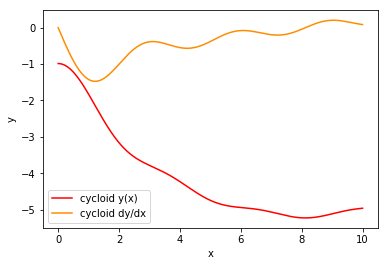

optimal elapsed time: 1.405702195366413 s


In [5]:
%matplotlib inline

xaxis = np.linspace(0, XFINAL, 1000)
cycloid_coefs = cycloid_coefficients(FOURIER_TERMS)
yaxis_cycloid = fourier_y(cycloid_coefs,xaxis)
ypaxis_cycloid = fourier_yp(cycloid_coefs,xaxis)

cycloid_y, = plt.plot(xaxis, yaxis_cycloid, color="red",label='cycloid y(x)')
cycloid_yp, = plt.plot(xaxis, ypaxis_cycloid, color="darkorange",label='cycloid dy/dx')
plt.legend(handles=[cycloid_y, cycloid_yp], loc=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print('Cycloid elapsed time:',delta_time(cycloid_coefs),'s')

# Alternative functions

To see how other functions compare to the optimal cycloid, we can decompose them into their fourier coeffcients and plug them into $\Delta t$ just the same. One such example is the straight line that connects $a = (0,0)$ to $b  = (x_f,y_f)$. The coeffcients for the line are:


$$ a_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} \frac{y_f}{x_f}x \cos(\frac{nx}{2 k}) dx = 0$$
$$ b_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} \frac{y_f}{x_f}x \sin(\frac{nx}{2 k}) dx $$

All the $a_n$ will be zero because the line is an odd function.

In [6]:
def line_coefficients(n):
    # n is number of sine coefficients and n+1 the number of cosine coeffcieints.
    # The line starts at (0,0) and ends at (XFINAL,YFINAL)
    # all Cosine terms are 0. Sine terms non-zero
    coefs = [0.0]*(2*n+1)
    def cos_coef(c,theta):
        return (YFINAL*theta/XFINAL)*(np.cos(c*theta/(2.*K)))
    def sin_coef(c,theta):
        return (YFINAL*theta/XFINAL)*(np.sin(c*theta/(2.*K)))
    for i in range(n):
        coefs[2*i] = 0.0
        coefs[2*i+1] = (1.0/(2.*np.pi*K))*integrate.quad(lambda x: sin_coef(i+1,x),-2*np.pi*K,2*np.pi*K,limit=200)[0]
    return np.array(coefs)

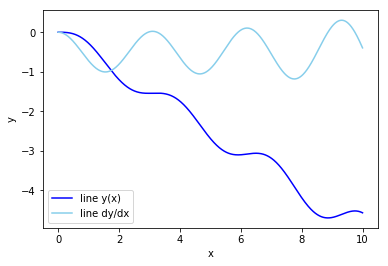

line elapsed time: 78.12613873125818 s


In [7]:
line_coefs = line_coefficients(FOURIER_TERMS)
yaxis_line = fourier_y(line_coefs,xaxis)
ypaxis_line = fourier_yp(line_coefs,xaxis)

line_y, = plt.plot(xaxis, yaxis_line, color="blue",label='line y(x)')
line_yp, = plt.plot(xaxis, ypaxis_line, color="skyblue",label='line dy/dx')
plt.legend(handles=[line_y, line_yp], loc=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print('line elapsed time:',delta_time(line_coefs),'s')

# Evolution Strategies and the Brachistochrone

A random set of fourier coefficients will create a random curve. This curve may go above the $y=0$ line, which violates a conservation of energy. A random curve will also likely not respect the boundry conditions of $a = (0,0)$ and $b  = (x_f,y_f)$. If we want to use an ML algorithm to find the brachistochrone curve without the help of Euler-Lagrange, we need to create a cost function that uses the $\Delta t$ function as a basis, and then has extra terms that heavily penalizes curves that do not follow the boundry conditions and conservation of energy. 

We can then use this new cost function as the fit function for the CMA-ES or OpenAI-ES algorithms. The evolving parameters are simply our fourier coeffcients. 

For the case where we are using few fourier coefficients, the approximation of the cycloid may not be the optimal choice, and the ES alogorithms may very well do better than our benchmark.

In [8]:
def print_dist_penalty(yax):
    begin_dist = math.fabs(yax[0]-(-0.00001))
    end_dist = math.fabs(yax[-1]-(YFINAL))
    begin_penalty = begin_dist**3
    end_penalty = end_dist**3
    print('  distance from x=0:',begin_dist,'distance from x=XFINAL:',end_dist)
    print('  penalty at x=0:',begin_penalty,'penalty at x=XFINAL:',end_penalty)

    
def cost_function(c_list):
    c_list = np.copy(c_list)
    def cost(x):
        #equation gotten from conservation of energy
        #due to conservation of energy, values of f(x) > 0 are impossible.
        #they will create a negative inside the sqrt and return an NaN
        return np.sqrt((1+fourier_yp(c_list,x)**2)/(2.0*g*fourier_y(c_list,x)))
    time = integrate.quad(cost,0.0001,XFINAL,limit=200)[0] #don't start integration from zero-- messes up integrator.
    #we also want to constrain the path to begin at (0,0) and end at (XFINAL,YFINAL)
    begin_penalty = math.fabs(fourier_y(c_list,0.0001)-(-0.00001))**3
    end_penalty = math.fabs(fourier_y(c_list,XFINAL)-YFINAL)**3
    return -1.*time-begin_penalty-end_penalty

fit_func = cost_function

In [9]:
NPARAMS = (FOURIER_TERMS*2)+1     # make this a 101-dimensinal problem.
NPOPULATION = 50    # use population size of 50.
MAX_ITERATION = 100 # run each solver for 100 generations.

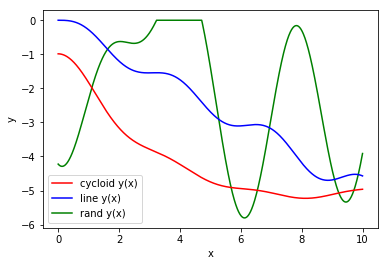

CYCLOID:
  fitness: -2.363965643067626
LINE:
  fitness: -78.20521660170998
RANDOM:
  fitness: -302.17298522071195


In [10]:
rand_coefs = np.random.randn(NPARAMS)
yaxis_rand = fourier_y(rand_coefs,xaxis)
rand_y, = plt.plot(xaxis, yaxis_rand, color="green",label='rand y(x)')
line_y, = plt.plot(xaxis, yaxis_line, color="blue",label='line y(x)')
optimal_y, = plt.plot(xaxis, yaxis_cycloid, color="red",label='cycloid y(x)')
plt.legend(handles=[optimal_y,line_y, rand_y], loc=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print('CYCLOID:')
print('  fitness:',cost_function(cycloid_coefs))
print('LINE:')
print('  fitness:',cost_function(line_coefs))
print('RANDOM:')
print('  fitness:',cost_function(rand_coefs))

In [11]:
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in range(MAX_ITERATION):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history.append((result[0],result[1]))
        if (j) % 2 == 0:
            print("fitness at iteration", (j), result[1])
    print("fitness score at this local optimum:", result[1])
    return history

In [12]:
# defines CMA-ES algorithm solver
cmaes = CMAES(NPARAMS,
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = 0.2
          )

(22_w,45)-aCMA-ES (mu_w=12.6,w_1=15%) in dimension 21 (seed=287127, Wed Sep  5 23:02:10 2018)


In [13]:
cma_history = test_solver(cmaes)


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


fitness at iteration 0 -276.87241030121993
fitness at iteration 2 -35.79302853810226


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)


fitness at iteration 4 -9.032885957234868
fitness at iteration 6 -3.4578131811388984
fitness at iteration 8 -3.2747537638619173
fitness at iteration 10 -3.2747537638619173
fitness at iteration 12 -3.2747537638619173
fitness at iteration 14 -3.2747537638619173
fitness at iteration 16 -3.2747537638619173
fitness at iteration 18 -2.829906545333838
fitness at iteration 20 -2.829906545333838
fitness at iteration 22 -1.9419396893352487
fitness at iteration 24 -1.9419396893352487
fitness at iteration 26 -1.9419396893352487
fitness at iteration 28 -1.9419396893352487
fitness at iteration 30 -1.9419396893352487
fitness at iteration 32 -1.9419396893352487
fitness at iteration 34 -1.9419396893352487
fitness at iteration 36 -1.9419396893352487
fitness at iteration 38 -1.9419396893352487
fitness at iteration 40 -1.8979007284525617
fitness at iteration 42 -1.8744199216586421
fitness at iteration 44 -1.78869023931772
fitness at iteration 46 -1.78869023931772
fitness at iteration 48 -1.78869023931772


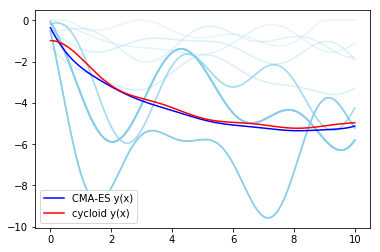

CYCLOID:
  fitness: -2.363965643067626
CMA-ES:
  fitness: -1.582408829213775


In [19]:
cma_coefs = cma_history[-1][0]
for i in range(len(cma_coefs)-1):
    yaxis_temp = fourier_y(cma_history[i][0],xaxis)
    plt.plot(xaxis, yaxis_temp, color="skyblue",alpha=0.2+0.6*(i/len(cma_coefs)))
yaxis_cma = fourier_y(cma_coefs,xaxis)
cma_y, = plt.plot(xaxis, yaxis_cma, color="blue",label='CMA-ES y(x)')
cycloid_y, = plt.plot(xaxis, yaxis_cycloid, color="red",label='cycloid y(x)')
plt.legend(handles=[cma_y, cycloid_y], loc=3)
plt.show()

print('CYCLOID:')
print('  fitness:',cost_function(cycloid_coefs))
print('CMA-ES:')
print('  fitness:',cost_function(cma_coefs))

In [15]:
# defines OpenAI's ES algorithm solver. Note that we needed to anneal the sigma parameter
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.5,            # initial standard deviation
            sigma_decay=0.999,         # don't anneal standard deviation
            learning_rate=0.1,         # learning rate for standard deviation
            learning_rate_decay = 1.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=False)

In [16]:
oes_history = test_solver(oes)

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


fitness at iteration 0 -126.513044557
fitness at iteration 2 -26.2818784544


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)


fitness at iteration 4 -8.1939710732
fitness at iteration 6 -2.7361651168
fitness at iteration 8 -2.7361651168
fitness at iteration 10 -2.11147330642
fitness at iteration 12 -2.11147330642
fitness at iteration 14 -2.11147330642
fitness at iteration 16 -2.11147330642
fitness at iteration 18 -2.11147330642
fitness at iteration 20 -2.03519623931
fitness at iteration 22 -2.03519623931
fitness at iteration 24 -2.03519623931
fitness at iteration 26 -2.0121464866
fitness at iteration 28 -2.0121464866
fitness at iteration 30 -2.0121464866
fitness at iteration 32 -2.0121464866
fitness at iteration 34 -2.0121464866
fitness at iteration 36 -2.0121464866
fitness at iteration 38 -2.0121464866
fitness at iteration 40 -2.0121464866
fitness at iteration 42 -2.0121464866
fitness at iteration 44 -2.0121464866
fitness at iteration 46 -2.0121464866
fitness at iteration 48 -2.0121464866
fitness at iteration 50 -2.0121464866
fitness at iteration 52 -2.0121464866
fitness at iteration 54 -2.0121464866
fitness

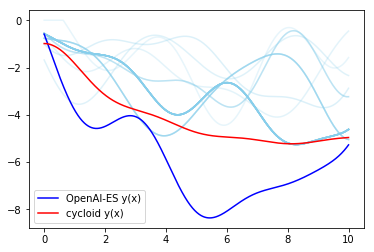

CYCLOID:
  fitness: -2.363965643067626
OpenAI-ES:
  fitness: -2.0121464866044554


In [21]:
oes_coefs = oes_history[-1][0]
for i in range(len(oes_coefs)-1):
    yaxis_temp = fourier_y(oes_history[i][0],xaxis)
    plt.plot(xaxis, yaxis_temp, color="skyblue",alpha=0.2+0.6*(i/len(cma_coefs)))
yaxis_oes = fourier_y(oes_coefs,xaxis)
oes_y, = plt.plot(xaxis, yaxis_oes, color="blue",label='OpenAI-ES y(x)')
cycloid_y, = plt.plot(xaxis, yaxis_cycloid, color="red",label='cycloid y(x)')
plt.legend(handles=[oes_y, cycloid_y], loc=3)
plt.show()

print('CYCLOID:')
print('  fitness:',cost_function(cycloid_coefs))
print('OpenAI-ES:')
print('  fitness:',cost_function(oes_coefs))

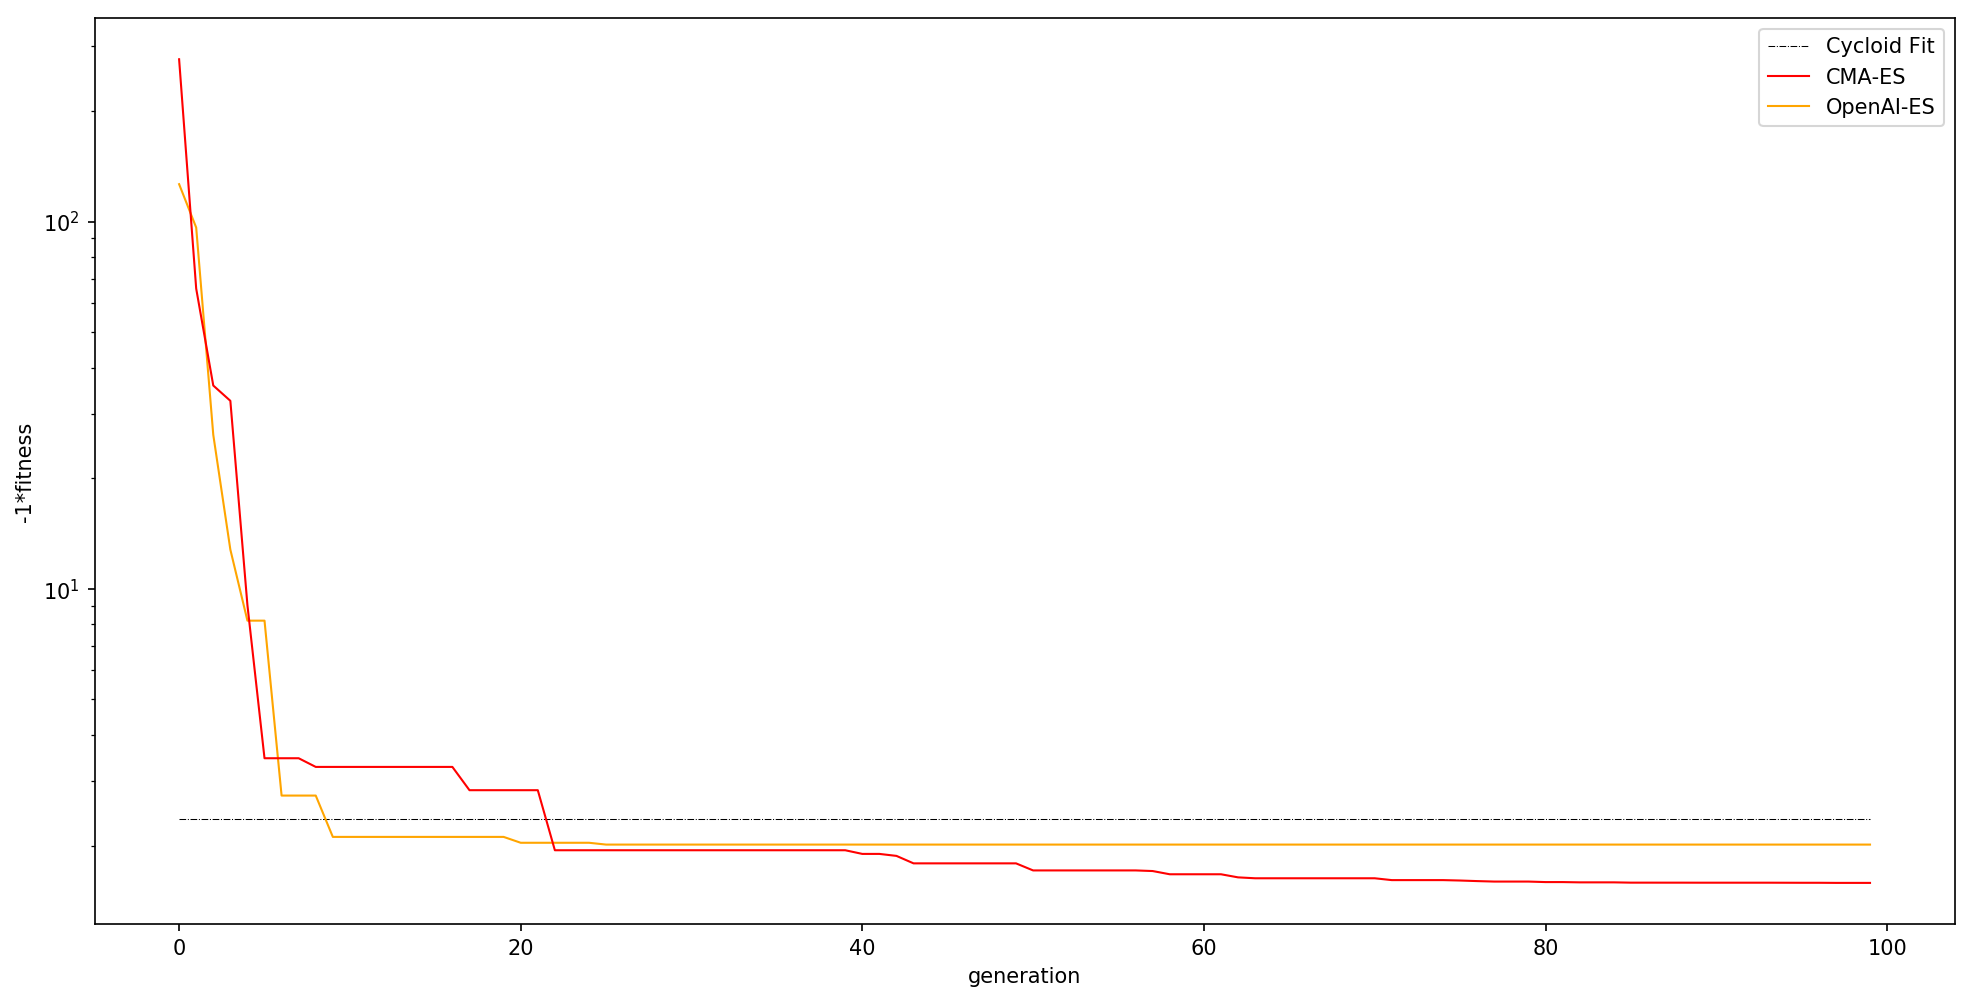

In [27]:
cycloid_fitness = [-cost_function(cycloid_coefs)] * MAX_ITERATION
plt.figure(figsize=(16,8), dpi=150)

oes_fitness = [-i[1] for i in oes_history ]
cma_fitness = [-i[1] for i in cma_history ]

cycloid_line, = plt.semilogy(cycloid_fitness, color="black", linewidth=0.5, linestyle="-.", label='Cycloid Fit')
oes_line, = plt.semilogy(oes_fitness, color="orange", linewidth=1.0, linestyle="-", label='OpenAI-ES')
cma_line, = plt.semilogy(cma_fitness, color="red", linewidth=1.0, linestyle="-", label='CMA-ES')

plt.legend(handles=[cycloid_line, cma_line, oes_line], loc=1)

# Set x limits
#plt.xlim(0,2500)

plt.xlabel('generation')
plt.ylabel('-1*fitness')

# plt.savefig("./rastrigin_10d.svg")

plt.show()